In [1]:
from lib.data_manager import DataManager

data_manager = DataManager()
users_df = data_manager.get_users_df()
tweets_df = data_manager.get_tweets_df()

In [2]:
import networkx as nx

user_graph = nx.DiGraph()

for _, user in users_df.iterrows():
    user_graph.add_node(user['user_id'])

for _, user in users_df.iterrows():
    for following_user_id in user['following']:
        user_graph.add_edge(user['user_id'], following_user_id, relation='follows')
    for follower_user_id in user['followers']:
        user_graph.add_edge(follower_user_id, user['user_id'], relation='follows')

for _, tweet in tweets_df.iterrows():
    if tweet['in_reply_to_user_id']:
        user_graph.add_edge(tweet['user_id'], tweet['in_reply_to_user_id'], relation='replies_to')
    if tweet.tweet_class == 'retweet':
        user_graph.add_edge(tweet['user_id'], tweet['thread_id'], relation='retweets')

In [3]:
import networkx as nx

self_loops = list(nx.selfloop_edges(user_graph))
if self_loops:
    print("Nodes with self-loops:")
    for u, v in self_loops:
        print(f"Node {u} has a self-loop")

Nodes with self-loops:
Node 1594903015 has a self-loop


In [4]:
tweets_df[tweets_df['user_id'] == 1594903015]

,thread_id,tweet_id,user_id,event,tweet_class,in_reply_to_status_id,in_reply_to_user_id,support,responsetype_vs_source,responsetype_vs_previous,favorite_count,retweet_count,created_at,place
207,521360486387175424,521360486387175424,1594903015,ebola-essien,source,0,0,supporting,NaN,NaN,328,781,Sun Oct 12 18:03:21 +0000 2014,NaN
213,521360486387175424,521378427681898498,1594903015,ebola-essien,direct reply,521360486387175424,1594903015,NaN,disagreed,NaN,47,65,Sun Oct 12 19:14:38 +0000 2014,NaN


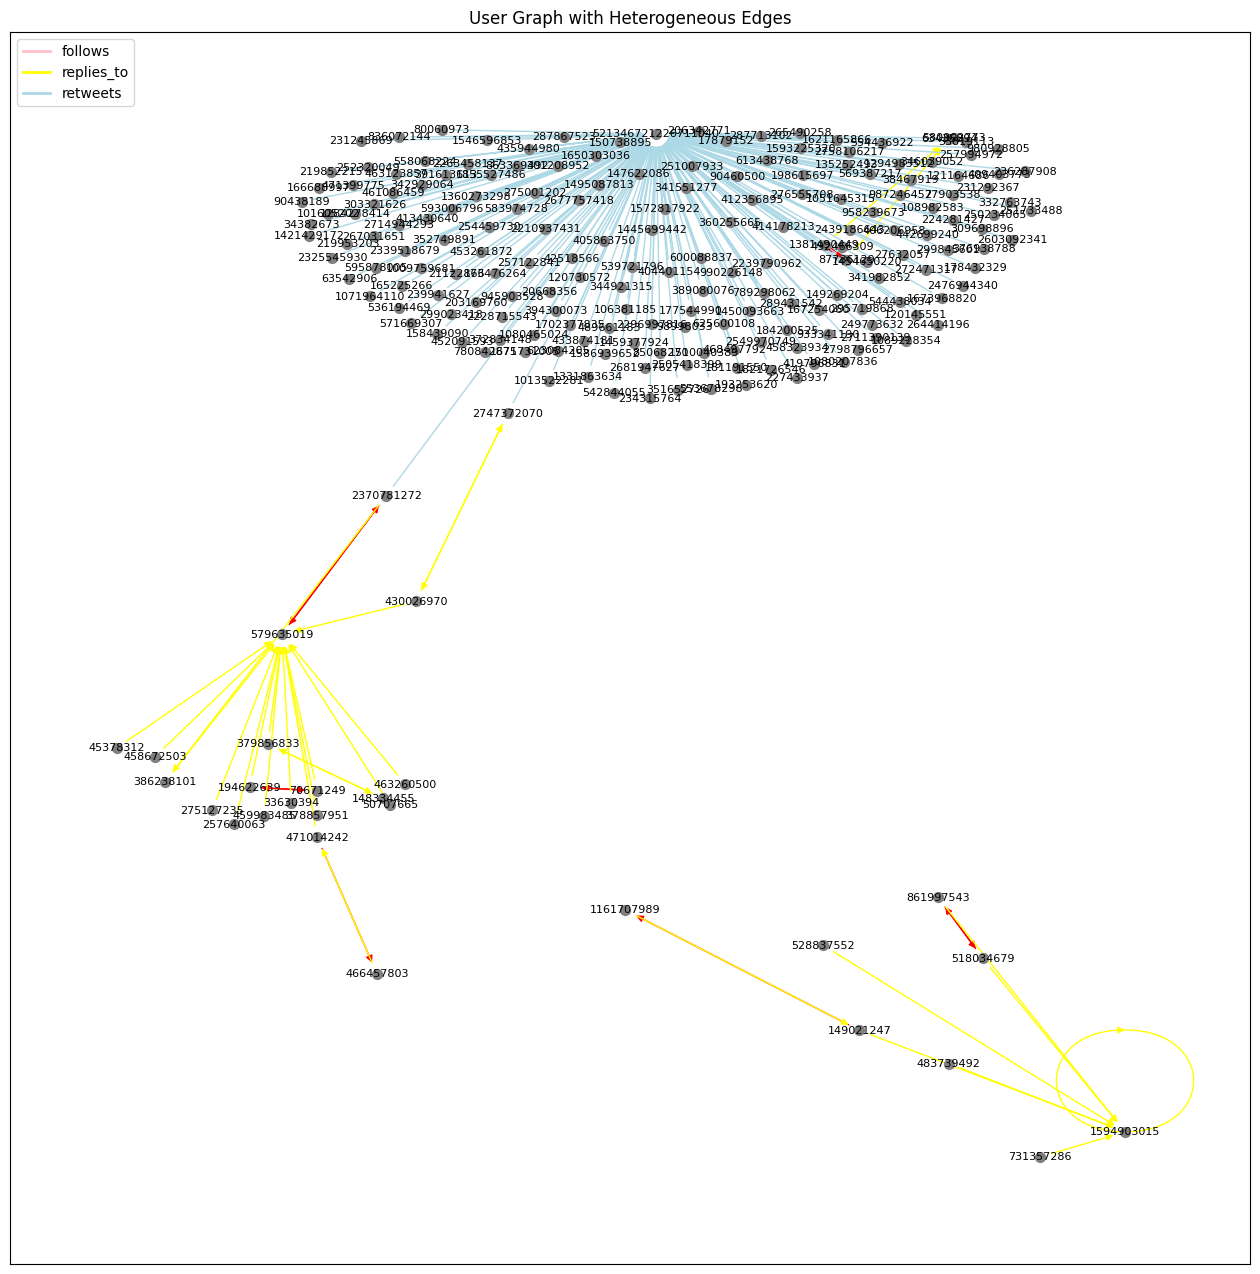

In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# A higher 'k' value means more space between nodes (try values from 0.2 to 1.0)
pos = nx.spring_layout(user_graph, k=0.2)
plt.figure(figsize=(16, 16))

# Draw nodes
nx.draw_networkx_nodes(user_graph, pos, node_size=50, node_color='grey')

# Draw edges with different colors based on the relationship type
edges_follows = [(u, v) for u, v, d in user_graph.edges(data=True) if d['relation'] == 'follows']
edges_replies_to = [(u, v) for u, v, d in user_graph.edges(data=True) if d['relation'] == 'replies_to']
edges_retweets = [(u, v) for u, v, d in user_graph.edges(data=True) if d['relation'] == 'retweets']

# Draw edges with specific colors
nx.draw_networkx_edges(user_graph, pos, edgelist=edges_follows, edge_color='red', label='follows')
nx.draw_networkx_edges(user_graph, pos, edgelist=edges_replies_to, edge_color='yellow', label='replies_to')
nx.draw_networkx_edges(user_graph, pos, edgelist=edges_retweets, edge_color='lightblue', label='retweets')

# Draw labels
nx.draw_networkx_labels(user_graph, pos, font_size=8)

# Custom legend for edges
legend_elements = [
    Line2D([0], [0], color='pink', lw=2, label='follows'),
    Line2D([0], [0], color='yellow', lw=2, label='replies_to'),
    Line2D([0], [0], color='lightblue', lw=2, label='retweets')
]

# Add the custom legend to the plot
plt.legend(handles=legend_elements, loc='upper left')

# Title and display the plot
plt.title("User Graph with Heterogeneous Edges")
plt.show()

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import takewhile

Number of communities: 6
Community 1: {558068224, 1572817922, 404401154, 933341190, 389080076, 135252493, 435944980, 2228715543, 257122841, 303321626, 42518566, 167254060, 90438189, 80060973, 231245869, 453261872, 27903538, 219953203, 299023418, 1650303036, 1855527486, 249773632, 1089228354, 539721796, 1331863634, 2210937431, 332763743, 1450093663, 267031651, 1593225320, 2758106217, 625600108, 17879152, 206342771, 595878005, 63542906, 459983485, 257640063, 1080465024, 287867523, 341982852, 492466309, 1284278414, 120145551, 198615697, 87786129, 542844055, 2505418399, 342929064, 394300073, 391613613, 623084205, 194622639, 341551277, 360255665, 158439090, 1673968820, 33630394, 1495087813, 147622086, 452091593, 593006796, 836072144, 250234065, 50707665, 2439186643, 149269204, 569387217, 2339518679, 257994972, 344921315, 990226148, 166688997, 193253620, 461086459, 489661183, 1459377924, 1586939652, 600088837, 433874181, 45378312, 346039052, 1381490449, 544438034, 98998033, 863369492, 272471

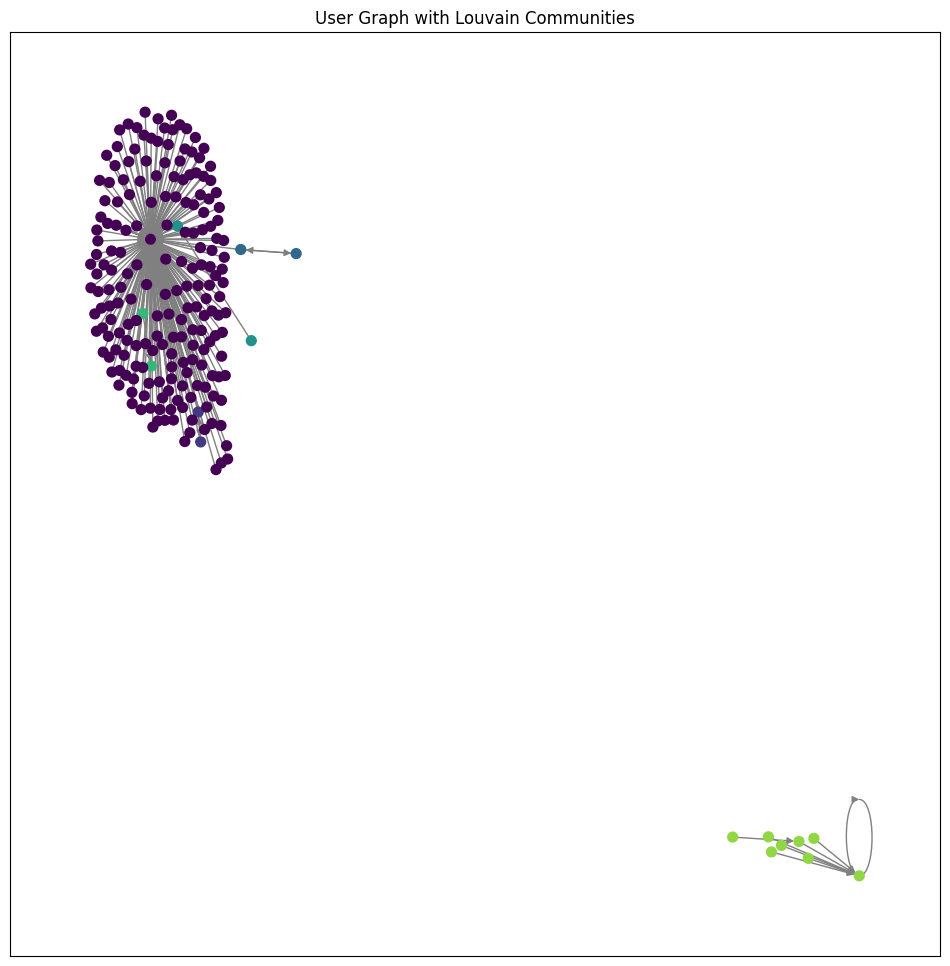

In [22]:
from networkx.algorithms.community import louvain_communities, girvan_newman

communities = louvain_communities(user_graph)
print(f"Number of communities: {len(communities)}")
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

pos = nx.spring_layout(user_graph)  # layout for nodes
cmap = plt.get_cmap('viridis')      # color map for the communities

# Create a mapping of nodes to community index
community_map = {node: i for i, community in enumerate(communities) for node in community}

# Assign a color to each node based on its community
colors = [cmap(community_map[node] / len(communities)) for node in user_graph.nodes()]

# Plot the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx(user_graph, pos, node_color=colors, with_labels=False, node_size=50, edge_color='gray')
plt.title("User Graph with Louvain Communities")
plt.show()

In [24]:
from networkx.algorithms.clique import find_cliques

cliques = list(find_cliques(user_graph.to_undirected()))
print(f"Number of cliques: {len(cliques)}")
for i, clique in enumerate(cliques):
    print(f"Clique {i + 1}: {clique}")

Number of cliques: 204
Clique 1: [483739492, 1594903015]
Clique 2: [731357286, 1594903015]
Clique 3: [1594903015, 528837552]
Clique 4: [1594903015, 861997543]
Clique 5: [1594903015, 149021247]
Clique 6: [1594903015, 518034679]
Clique 7: [579635019, 558068224]
Clique 8: [579635019, 404401154]
Clique 9: [579635019, 1572817922]
Clique 10: [579635019, 933341190]
Clique 11: [579635019, 389080076]
Clique 12: [579635019, 135252493]
Clique 13: [579635019, 435944980]
Clique 14: [579635019, 2228715543]
Clique 15: [579635019, 257122841]
Clique 16: [579635019, 303321626]
Clique 17: [579635019, 2747372070, 430026970]
Clique 18: [579635019, 42518566]
Clique 19: [579635019, 167254060]
Clique 20: [579635019, 80060973]
Clique 21: [579635019, 90438189]
Clique 22: [579635019, 231245869]
Clique 23: [579635019, 453261872]
Clique 24: [579635019, 27903538]
Clique 25: [579635019, 219953203]
Clique 26: [579635019, 299023418]
Clique 27: [579635019, 1650303036]
Clique 28: [579635019, 1855527486]
Clique 29: [5796

In [25]:
# Calculate assortativity coefficient for the given attribute
attribute = "favorite_count"
assortativity = nx.attribute_assortativity_coefficient(user_graph, attribute)
print(f"Assortativity coefficient for {attribute}: {assortativity}")


Assortativity coefficient for favorite_count: nan


/mnt/c/Users/tranh/Desktop/unistuff/MSc/2ia/SNA/RumourDetection/.venv/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)


In [27]:
from networkx.algorithms.centrality import betweenness_centrality

# Calculate betweenness centrality
betweenness = betweenness_centrality(user_graph)
# Find nodes with high betweenness centrality
bridges = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
print("Nodes acting as bridges (high betweenness centrality):")
for node, centrality in bridges[:10]:  # Top 10 bridges
    print(f"Node {node}: {centrality}")

Nodes acting as bridges (high betweenness centrality):
Node 379856833: 2.3451057642699685e-05
Node 471014242: 2.3451057642699685e-05
Node 149021247: 2.3451057642699685e-05
Node 579635019: 0.0
Node 463260500: 0.0
Node 430026970: 0.0
Node 458672503: 0.0
Node 45378312: 0.0
Node 459983485: 0.0
Node 378857951: 0.0
